# Remove outliers

Scine we already performed initial data analysies, we just need to re-dowlnoad data sets and execute it with removed outliers baised on z-score > 3. It was assumed that the best course of action for this data set would be utilizing z-score since it meet all statistical and scientific needs.

In [35]:
#cleaned modules
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import skew
from sklearn import preprocessing
import keras
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, recall_score, precision_score, classification_report, mean_squared_error, precision_recall_fscore_support, r2_score
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [36]:
# create new dataframe with raw data
df_raw = pd.read_csv('Occupancy_Estimation.csv')

In [37]:
# create new dataframe for modifications
df = df_raw.copy()

In [38]:
# create Datetime column

# combine into a single column
df['Datetime'] = df['Date'] + ' ' + df['Time']

# convert to datetime, specify that year comes first in the format
df['Datetime'] = pd.to_datetime(df['Datetime'], yearfirst=True)

In [39]:
# convert to date and time data types
df['Date'] = df['Datetime'].dt.date
df['Time'] = df['Datetime'].dt.time

In [40]:
# create new columns for combined (average) temperature, light, and sound
df['Temp'] = (df['S1_Temp'] + df['S2_Temp'] + df['S3_Temp'] + df['S4_Temp'] / 4)
df['Light'] = (df['S1_Light'] + df['S2_Light'] + df['S3_Light'] + df['S4_Light'] / 4)
df['Sound'] = (df['S1_Sound'] + df['S2_Sound'] + df['S3_Sound'] + df['S4_Sound'] / 4)

In [41]:
# drop individual reading columns for temperature, light, and sound
df = df.drop(columns=['S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp'])
df = df.drop(columns=['S1_Light', 'S2_Light', 'S3_Light', 'S4_Light'])
df = df.drop(columns=['S1_Sound', 'S2_Sound', 'S3_Sound', 'S4_Sound'])

In [42]:
# columns to rename
renaming = {'S5_CO2': 'CO2', 
            'S5_CO2_Slope': 'CO2_Slope', 
            'S6_PIR': 'PIR_S1', 
            'S7_PIR': 'PIR_S2',}

# rename columns in existing dataframe
df = df.rename(renaming, axis=1)

# reorder columns in existing dataframe
df = df[['Datetime', 'Date', 'Time', 'Temp', 'Light', 'Sound', 'CO2', 'CO2_Slope', 'PIR_S1', 'PIR_S2', 'Room_Occupancy_Count']]

In [43]:
from scipy import stats

# define a threshold value for the z-score
threshold = 3

# select the columns we want to clean
selected_columns = ['Temp', 'Light', 'Sound', 'CO2', 'CO2_Slope', 'PIR_S1', 'PIR_S2', 'Room_Occupancy_Count']
selected_df = df[selected_columns]

# calculate the z-scores for each column in the dataframe
z_scores = stats.zscore(selected_df)

# get the absolute z-scores for each data point
abs_z_scores = np.abs(z_scores)

# create a boolean mask for each row, indicating whether it's an outlier or not
mask = (abs_z_scores < threshold).all(axis=1)

# create a new dataframe with the cleaned data
clean_df = df[mask]

# save the cleaned dataframe to a new CSV file
clean_df.to_csv('cleaned_data.csv', index=False)

In [44]:
df = clean_df

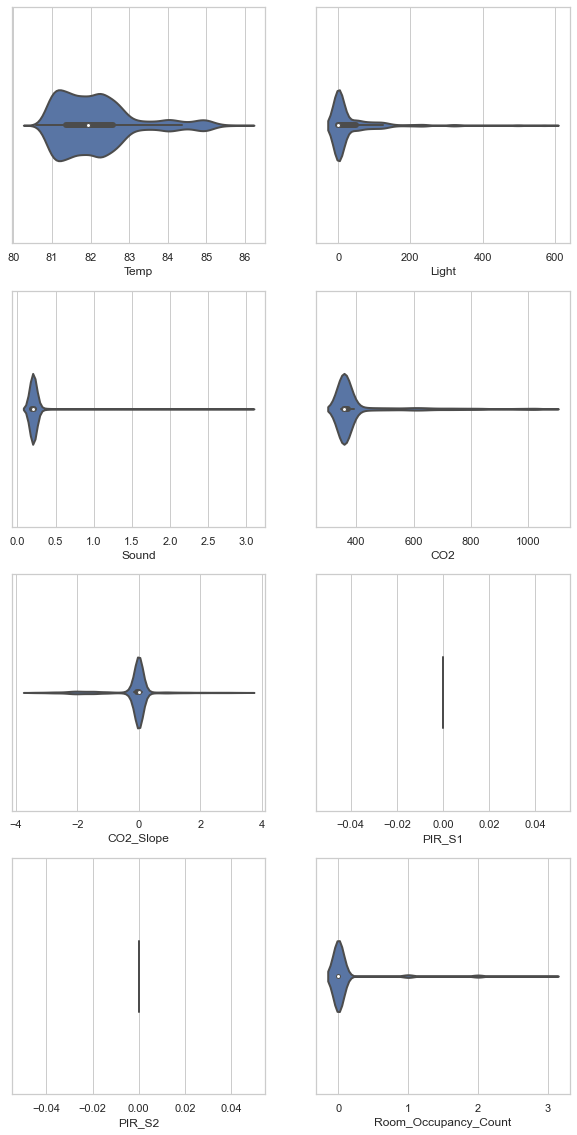

In [45]:
# create violinplots for each feature
fig, axs = plt.subplots(4, 2, figsize=(10, 20))

sns.violinplot(data=df, x='Temp', width=.3, linewidth=2, fliersize=5, showfliers=False, ax=axs[0, 0])
sns.violinplot(data=df, x='Light', width=.3, linewidth=2, fliersize=5, showfliers=False, ax=axs[0, 1])
sns.violinplot(data=df, x='Sound', width=.3, linewidth=2, fliersize=5, showfliers=False, ax=axs[1, 0])
sns.violinplot(data=df, x='CO2', width=.3, linewidth=2, fliersize=5, showfliers=False, ax=axs[1, 1])
sns.violinplot(data=df, x='CO2_Slope', width=.3, linewidth=2, fliersize=5, showfliers=False, ax=axs[2, 0])
sns.violinplot(data=df, x='PIR_S1', width=.3, linewidth=2, fliersize=5, showfliers=False, ax=axs[2, 1])
sns.violinplot(data=df, x='PIR_S2', width=.3, linewidth=2, fliersize=5, showfliers=False, ax=axs[3, 0])
sns.violinplot(data=df, x='Room_Occupancy_Count', width=.3, linewidth=2, fliersize=5, showfliers=False, ax=axs[3, 1])

plt.show()

We can see that the Room Occupancy is empty (i.e., 0) for the majority of the time readings were collected.  This explains why most of our data does not appear to be normally distributed.  Most values are skewed to the left, indicating no or low sensor readings while rooms are vacant.  We will likely need to consider data tranformations and/or normalizations prior to training our machine learning models. After removing some outliers we observe some changes, data set became more deffined. On the other hand we observe some data loss on a big scale. For example PIR_S2 and PIR_S1 completelly disapeared.

In [46]:
# calculate the skewness
Temp_skewness = skew(df['Temp'])
Light_skewness = skew(df['Light'])
Sound_skewness = skew(df['Sound'])
CO2_skewness = skew(df['CO2'])
CO2_Slope_skewness = skew(df['CO2_Slope'])
PIR_S1_skewness = skew(df['PIR_S1'])
PIR_S2_skewness = skew(df['PIR_S2'])
Room_Occupancy_Count_skewness = skew(df['Room_Occupancy_Count'])

print(f"Skewness Temp = {Temp_skewness:.2f}")
print(f"Skewness Light = {Light_skewness:.2f}")
print(f"Skewness Sound = {Sound_skewness:.2f}")
print(f"Skewness CO2 = {CO2_skewness:.2f}")
print(f"Skewness CO2_Slope = {CO2_Slope_skewness:.2f}")
print(f"Skewness PIR_S1 = {PIR_S1_skewness:.2f}")
print(f"Skewness PIR_S2 = {PIR_S2_skewness:.2f}")
print(f"Skewness Room_Occupancy_Count = {Room_Occupancy_Count_skewness:.2f}")

Skewness Temp = 1.18
Skewness Light = 3.45
Skewness Sound = 6.76
Skewness CO2 = 2.79
Skewness CO2_Slope = -0.98
Skewness PIR_S1 = 0.00
Skewness PIR_S2 = 0.00
Skewness Room_Occupancy_Count = 4.33


Relative to previouse results (Skewness Temp = 1.06
Skewness Light = 2.17
Skewness Sound = 4.69
Skewness CO2 = 1.98
Skewness CO2_Slope = 0.29
Skewness PIR_S1 = 2.86
Skewness PIR_S2 = 3.11
Skewness Room_Occupancy_Count = 2.06))
Most of our data points became significanetelly more skewed to the right with two major changes Room_Occupancy_Count with the most drastic change in CO2_Slope. Which most likelly will affect our final results.

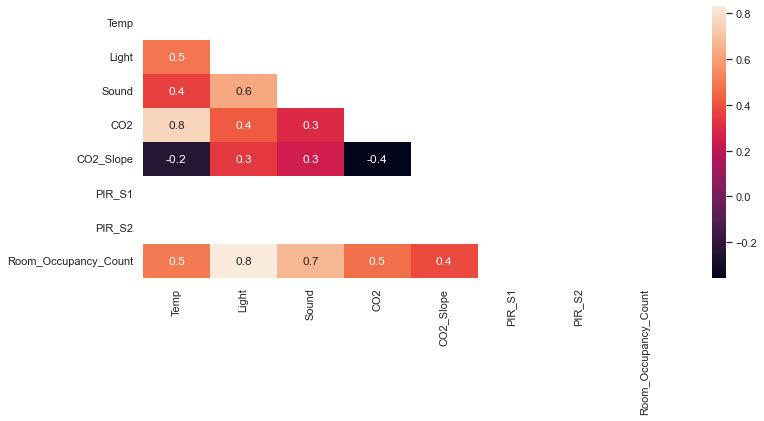

In [47]:
# find relationship between columns in form of a heat map
sns.heatmap(df.corr(), annot=True, fmt=".1f", mask=np.triu(df.corr()));

As we can see, there are some drastic changes in our heatmap. Now, Temp has less correlation with ROC (Room_Occupancy_Count) as well as with all other parameters. A similar situation is observed with CO2, with the exception of CO2 vs Temp. In general, we observe some fundamental changes that should positively affect our data, especially after losing two of our initial columns, PIR_S1 and PIR_S2. The loss of those two columns is neither negative nor positive because it is likely that they were affected by other factors that are beyond our control.

## Machine Learning Tasks

Let's performe model's training baised on data set with removed outliers with same parameters.

### Deep Learning LSTM Time Series Prediction for Room Occupancy Count

In [48]:
# create new copy of dataframe
df_lstm = df.copy()
# find location which splits df_lstm into 80% and 20%
loc_split = round((df_lstm.shape[0]*.80))

# create train_df using 80% of df_lstm
train_df = df_lstm.iloc[0:loc_split]

# create val_df using remaining 20% of df_lstm
val_df = df_lstm.iloc[loc_split:]

# reset validation dataframe index for cleanliness
val_df = val_df.reset_index()

# MinMax normalization (from 0 to 1)

# select columns to normalize, exclude non-numeric, Datetime, PIR sensors, and output feature
cols_normalize = train_df.columns.difference(['Date', 'Time', 'Datetime', 'Room_Occupancy_Count'])

# scale selected columns between 0 and 1
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)

# recombine scaled columns with the training dataframe
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)

# define sequence length and prediction horizon
seq_length = 25
ph = 1

# pick the feature columns 
feat_cols = ['Temp']

# create nested list structure
seq_arrays = []
seq_labs = []

# create list of sequence length temperature readings
rlen = len(train_df) - seq_length - ph
for start in range(0, rlen):
    seq_arrays.append(train_df[feat_cols].iloc[start:start+seq_length].to_numpy())
    seq_labs.append([train_df['Room_Occupancy_Count'].iloc[start:start+seq_length+ph].to_numpy()[-1]])
    
#convert to numpy arrays and floats to appease keras/tensorflow        
seq_arrays = np.array(seq_arrays, dtype = object).astype(np.float32)
seq_labs = np.array(seq_labs, dtype = object).astype(np.float32)

# assert statements to verify we have our expected array shapes
assert(seq_arrays.shape == (len(train_df)-seq_length-ph, seq_length, len(feat_cols)))
assert(seq_labs.shape == (len(train_df)-seq_length-ph, 1))

#########MODEL TRAINING########
# define path to save model
model_path = 'LSTM_model1.h5'

# build the network
nb_features = seq_arrays.shape[2]
nb_out = seq_labs.shape[1]

# create sequential model object
model = Sequential()

#add first LSTM layer
model.add(LSTM(
         input_shape=(seq_length, nb_features),
         units=5, 
         return_sequences=True))
model.add(Dropout(0.2)) 

# add second LSTM layer
model.add(LSTM(
          units=3,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=nb_out))
model.add(Activation('linear'))
optimizer = keras.optimizers.Adam(learning_rate = 0.005)
model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])

# print model summary
print(model.summary())

# fit the model
history = model.fit(seq_arrays, seq_labs, epochs=100, batch_size=125, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# list all data in history
print(history.history.keys())




Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 25, 5)             140       
                                                                 
 dropout_2 (Dropout)         (None, 25, 5)             0         
                                                                 
 lstm_3 (LSTM)               (None, 3)                 108       
                                                                 
 dropout_3 (Dropout)         (None, 3)                 0         
                                                                 
 dense_5 (Dense)             (None, 1)                 4         
                                                                 
 activation_1 (Activation)   (None, 1)                 0         
                                                                 
Total params: 252
Trainable params: 252
Non-trainable 

Epoch 62/100
53/53 - 1s - loss: 0.0989 - mse: 0.0989 - val_loss: 0.2861 - val_mse: 0.2861 - 851ms/epoch - 16ms/step
Epoch 63/100
53/53 - 1s - loss: 0.0949 - mse: 0.0949 - val_loss: 0.3434 - val_mse: 0.3434 - 827ms/epoch - 16ms/step
Epoch 64/100
53/53 - 1s - loss: 0.0904 - mse: 0.0904 - val_loss: 0.3140 - val_mse: 0.3140 - 849ms/epoch - 16ms/step
Epoch 65/100
53/53 - 1s - loss: 0.0883 - mse: 0.0883 - val_loss: 0.2944 - val_mse: 0.2944 - 829ms/epoch - 16ms/step
Epoch 66/100
53/53 - 1s - loss: 0.0893 - mse: 0.0893 - val_loss: 0.2902 - val_mse: 0.2902 - 835ms/epoch - 16ms/step
Epoch 67/100
53/53 - 1s - loss: 0.0853 - mse: 0.0853 - val_loss: 0.3305 - val_mse: 0.3305 - 854ms/epoch - 16ms/step
Epoch 68/100
53/53 - 1s - loss: 0.0834 - mse: 0.0834 - val_loss: 0.3132 - val_mse: 0.3132 - 834ms/epoch - 16ms/step
dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])


Our MSE is already smaller than from previouse tries.

#### plot results

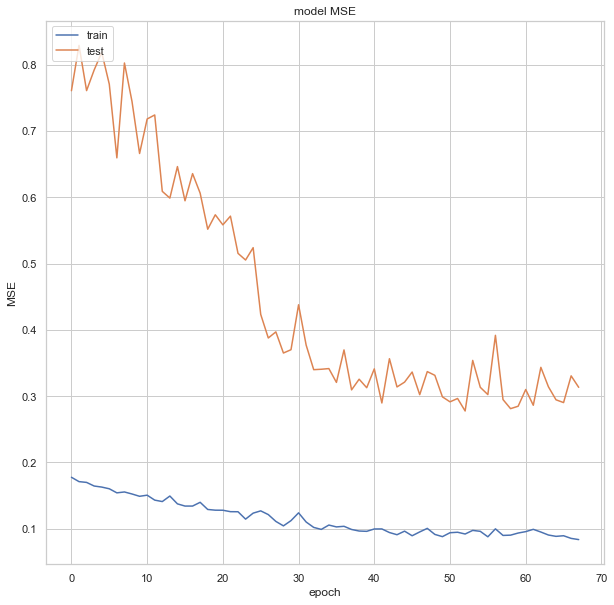

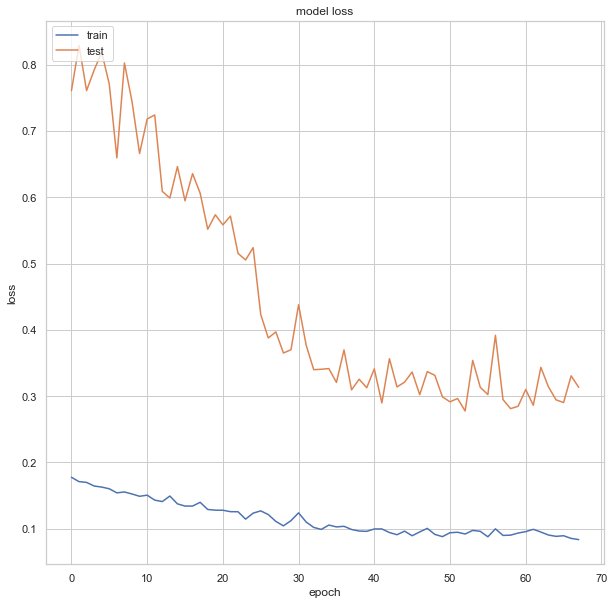

In [49]:
# summarize history for MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_mse1.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_loss1.png")

#### Model Validation

In order to validate our model, we will create a simulated "production" dataset.  This will mimic a streaming dataset, so any data sequences less than our defined sequence length will be padded with zeroes to ensure the correct sequence length is used until the number of readings streamed equal the defined sequence length.

In [50]:
# create arrays for validation dataset inputs and output
val_arrays = []
val_labs = []

# create list of temperature readings starting with a minimum of two readings
rlen = len(val_df) - ph
for end in range(2, rlen):
    if (end < seq_length):
        val_arrays.append(val_df[feat_cols][0:end].to_numpy())
        val_labs.append(val_df['Room_Occupancy_Count'][end+ph])
    # add sequences of defined seq_length once we have enough readings
    else:
        val_arrays.append(val_df[feat_cols][end-seq_length:end].to_numpy())
        val_labs.append(val_df['Room_Occupancy_Count'][end+ph])

# use pad_sequences function on input sequences, specify np.float32 to appease keras/tensorflow
val_arrays = pad_sequences(val_arrays, maxlen = seq_length, dtype = np.float32)

#convert labels to numpy arrays and floats to appease keras/tensorflow
val_labs = np.array(val_labs, dtype = object).astype(np.float32)

55/55 - 1s - loss: 4.9456 - mse: 4.9456 - 1s/epoch - 26ms/step

MSE: 4.945613861083984
55/55 [==============================] - 1s 4ms/step


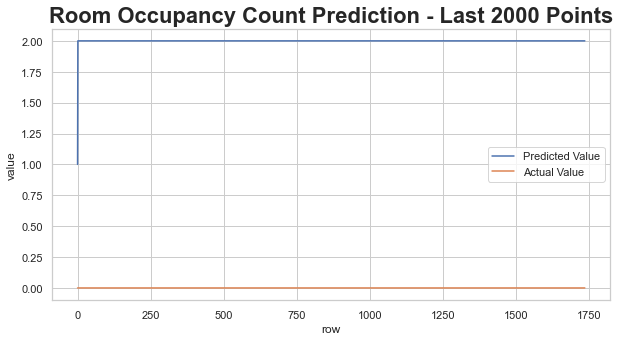

In [51]:
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

y_pred_test = model.predict(val_arrays)
y_pred_test2 = np.floor(y_pred_test) # round down to nearest integer
y_true_test = val_labs

test_set = pd.DataFrame(y_pred_test2)
test_set.to_csv('submit_test.csv', index = None)

# plot the predicted data vs. the actual data
# we will limit our plot to the last 2000 predictions for better visualization
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test2[-2000:], label = 'Predicted Value')
plt.plot(y_true_test[-2000:], label = 'Actual Value')
plt.title('Room Occupancy Count Prediction - Last 2000 Points', fontsize=22, fontweight='bold')
plt.ylabel('value')
plt.xlabel('row')
plt.legend()
plt.show()
fig_verify.savefig("model_regression_verify.png")

Our validation did not perform as well as our previous test data.  Unfortunately, we believe this is, in part, because of the lack of sufficient data.  The majority of our validation data has 0 for the true value of Room Occupancy Count.  We can take a look at the breakdown of our output feature's actual values.

In [52]:
# print output feature value counts for both the original dataframe and validation dataframe
print ('Original Dataframe:\n',(df_raw.groupby(['Room_Occupancy_Count'])['Room_Occupancy_Count'].count()))
print ('\nValidation Dataframe:\n',(val_df.groupby(['Room_Occupancy_Count'])['Room_Occupancy_Count'].count()))

Original Dataframe:
 Room_Occupancy_Count
0    8228
1     459
2     748
3     694
Name: Room_Occupancy_Count, dtype: int64

Validation Dataframe:
 Room_Occupancy_Count
0    1741
Name: Room_Occupancy_Count, dtype: int64


### Task 1b - Deep Learning Model Prediction for Room Occupancy Count

In [53]:
df_dl = df.copy()
# Divide the data in to features - X and labels - y (Room_Occupancy_Count)

labels = df_dl.pop('Room_Occupancy_Count').values.astype('float32')
features = df_dl.iloc[:,3:].values.astype('float32') # All the sensor readings except for Room_Occupancy_count
# Divide the data into train set, validation set, and test set

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=.1) 
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=.1)
# Use MinMaxScaler to normalize the input data

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)
# Change the labels dataset to one_hot. With one-hot, we convert each categorical value into a new categorical 
# column and assign a binary value of 1 or 0 to those columns. Here count values are one of - 0, 1, 2 or 3.

y_train, y_valid, y_test = to_categorical(y_train),to_categorical(y_valid), to_categorical(y_test)

# half the learning rate when val_loss stop reduce during training
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                               patience=3,
                                                               verbose=0,
                                                               factor=.5,
                                                               min_lr=.00001)

In [54]:
model_class = tf.keras.Sequential([
    tf.keras.layers.Dense(128,activation='relu',input_shape=[7]),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(4,activation='softmax') # Output 4 units representing the Occupancy Number 0, 1, 2, 3
])

model_class.compile(loss='categorical_crossentropy',
             optimizer=tf.keras.optimizers.Adam(),
             metrics=['accuracy'])

print(model_class.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 128)               1024      
                                                                 
 dense_7 (Dense)             (None, 128)               16512     
                                                                 
 dense_8 (Dense)             (None, 128)               16512     
                                                                 
 dense_9 (Dense)             (None, 4)                 516       
                                                                 
Total params: 34,564
Trainable params: 34,564
Non-trainable params: 0
_________________________________________________________________
None


In [55]:
history = model_class.fit(X_train_scaled,y_train,
                epochs=50,
                batch_size=32,
                validation_data=(X_valid_scaled,y_valid),
                callbacks=[learning_rate_reduction],
                verbose=1)

# list all data in history
print(history.history.keys())

Epoch 1/50
221/221 [==============================] - 1s 3ms/step - loss: 0.2288 - accuracy: 0.9528 - val_loss: 0.0546 - val_accuracy: 0.9872 - lr: 0.0010
Epoch 2/50
221/221 [==============================] - 1s 2ms/step - loss: 0.0472 - accuracy: 0.9881 - val_loss: 0.0306 - val_accuracy: 0.9936 - lr: 0.0010
Epoch 3/50
221/221 [==============================] - 0s 2ms/step - loss: 0.0307 - accuracy: 0.9912 - val_loss: 0.0106 - val_accuracy: 0.9974 - lr: 0.0010
Epoch 4/50
221/221 [==============================] - 0s 2ms/step - loss: 0.0222 - accuracy: 0.9935 - val_loss: 0.0092 - val_accuracy: 0.9962 - lr: 0.0010
Epoch 5/50
221/221 [==============================] - 0s 2ms/step - loss: 0.0160 - accuracy: 0.9943 - val_loss: 0.0025 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 6/50
221/221 [==============================] - 0s 2ms/step - loss: 0.0137 - accuracy: 0.9955 - val_loss: 0.0028 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 7/50
221/221 [==============================] - 0s 2ms/step - lo

we observe decrease in loss and an increase in accuracy

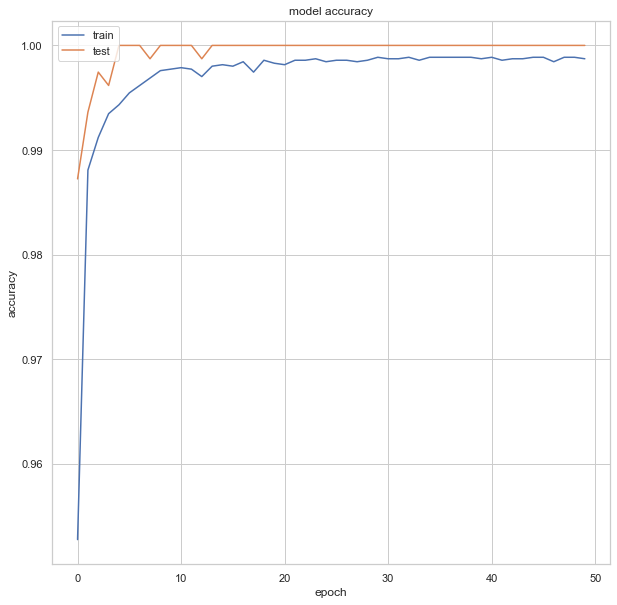

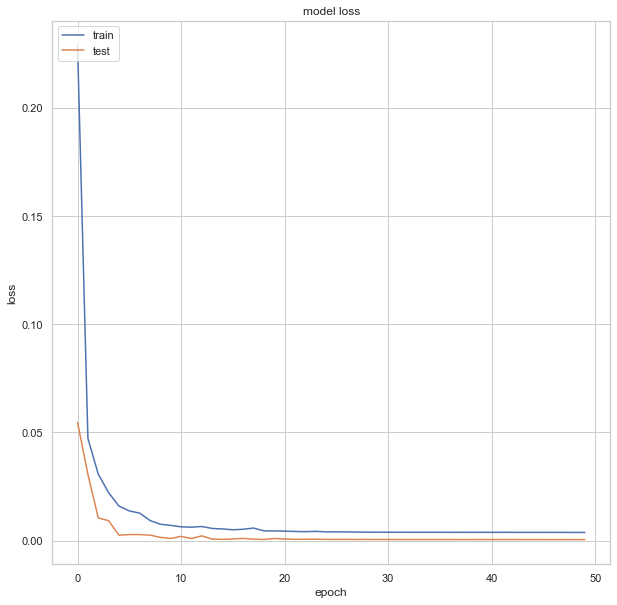

221/221 [==============================] - 0s 2ms/step - loss: 0.0037 - accuracy: 0.9989
Accuracy: 0.9988654255867004
221/221 [==============================] - 0s 1ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[6546    0    0    0]
 [   0  241    0    0]
 [   0    0  192    6]
 [   2    0    0   64]]
precision =  0.998865409161821 



In [56]:
# summarize history for Accuracy
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_accuracy.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_loss.png")

# training metrics
scores = model_class.evaluate(X_train_scaled, y_train, verbose=1, batch_size=32)
print('Accuracy: {}'.format(scores[1]))

# make predictions and compute confusion matrix
y_pred = model_class.predict(X_train_scaled,verbose=1, batch_size=32)
y_pred = np.argmax(y_pred, axis=1)
# y_true = y_train
y_true = np.argmax(y_train, axis=1)

test_set = pd.DataFrame(y_pred)
test_set.to_csv('binary_submit_train.csv', index = None)

print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
print(cm)

# compute precision and recall
precision = precision_score(y_true, y_pred, average='micro')
#recall = recall_score(y_true, y_pred.round, average='micro')
#print( 'precision = ', precision, '\n', 'recall = ', recall)
print( 'precision = ', precision, '\n')

Improvement of confusion for all dimensions inlcudin precission from precision =  0.9931740614334471 to precision =  0.9991490568713658 

#### Model Validation

In [57]:
# Calculate bias
bias = np.mean(y_pred) - np.mean(y_test)
print("Bias:", bias)

Bias: -0.13157708126506878


Relative to previous results, our bias for this model was 0.1478, and the current bias is -0.1316. Although both models still have high bias, the bias for the current model decreased after removing outliers. It is true that a negative bias value indicates that the estimator is underestimating the true value of the parameter on average. However, the previous bias value of 0.1478 overestimated the results by 10.961 percent. It means that underestimated results are 10.961 percent closer to actual value than overestimated. Taking everything into account, the new result is substantially better.

In [58]:
def process_data(data):
    return np.array(tf.argmax(data,axis=1),dtype='float32')

y_pred = process_data(model_class.predict(X_test_scaled))

print(classification_report(tf.argmax(y_test,axis=1),y_pred))

28/28 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       816
           1       1.00      1.00      1.00        25
           2       1.00      1.00      1.00        19
           3       1.00      1.00      1.00        11

    accuracy                           1.00       871
   macro avg       1.00      1.00      1.00       871
weighted avg       1.00      1.00      1.00       871



As we can see, there is an improvement in precision and a slight decrease in recall. However, we lost a little bit on recall, but the gain in precision is more substantial with respect to the model's reliability.

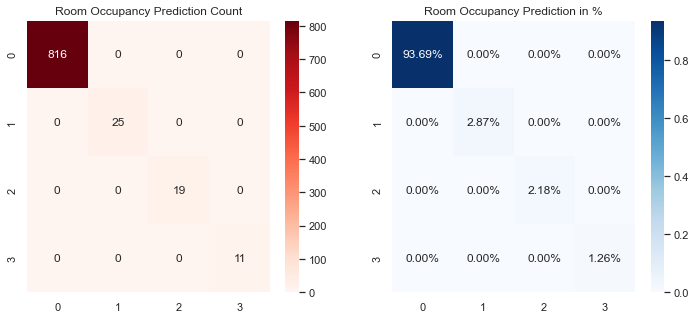

In [59]:
cf_matrix = confusion_matrix(tf.argmax(y_test, axis=1),y_pred)
sns.set_theme(style='whitegrid',rc={'figure.figsize':(12,5)})

fig, axs = plt.subplots(1,2)

# Number count
ax1 = sns.heatmap(cf_matrix,annot=True,cmap='Reds', ax=axs[0], fmt="g")
ax1.set_title('Room Occupancy Prediction Count')

# Percentage
ax2 = sns.heatmap(cf_matrix/np.sum(cf_matrix),annot=True,fmt='.2%',cmap='Blues',ax=axs[1])
ax2.set_title('Room Occupancy Prediction in %');

The model has improved beyond any imagination. The previous result was 81.34%, compared to the current result of 93.11%, which is an increase of more than 12%. Removing outliers had a dramatic effect on the deep learning model. We did not expect the model's results to improve on such a scale.

# XGBoost

In [60]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[['Temp', 'Light', 'Sound', 'Room_Occupancy_Count']], df['CO2'], test_size=0.2, random_state=2000000)

# Define the XGBoost model
xgb_model = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate=0.25,
                max_depth=5000, n_estimators=100)

# Train the XGBoost model
xgb_model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = xgb_model.predict(X_test)

# Evaluate the model using mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 103.1183623183229


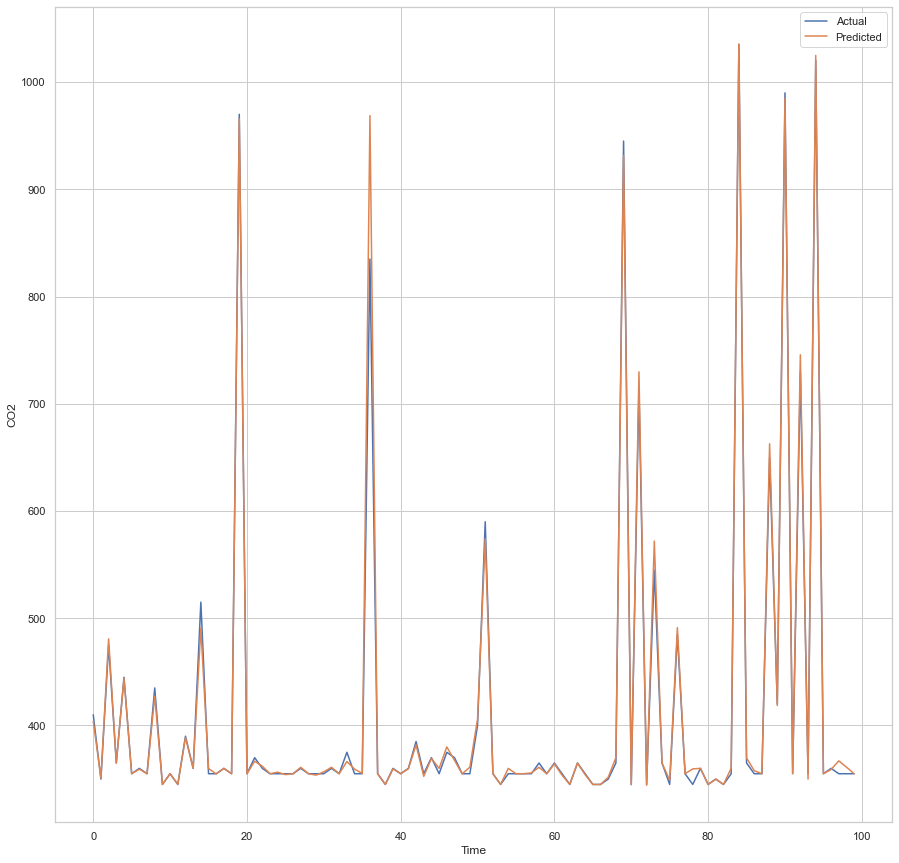

In [61]:
# Set the figure size
plt.figure(figsize=(15, 15))

# Plot the last 100 actual CO2 values and the predicted values over time
plt.plot(y_test.values[-100:], label='Actual')
plt.plot(y_pred[-100:], label='Predicted')
plt.xlabel('Time (Steps)')
plt.ylabel('CO2')
plt.legend()
plt.show()


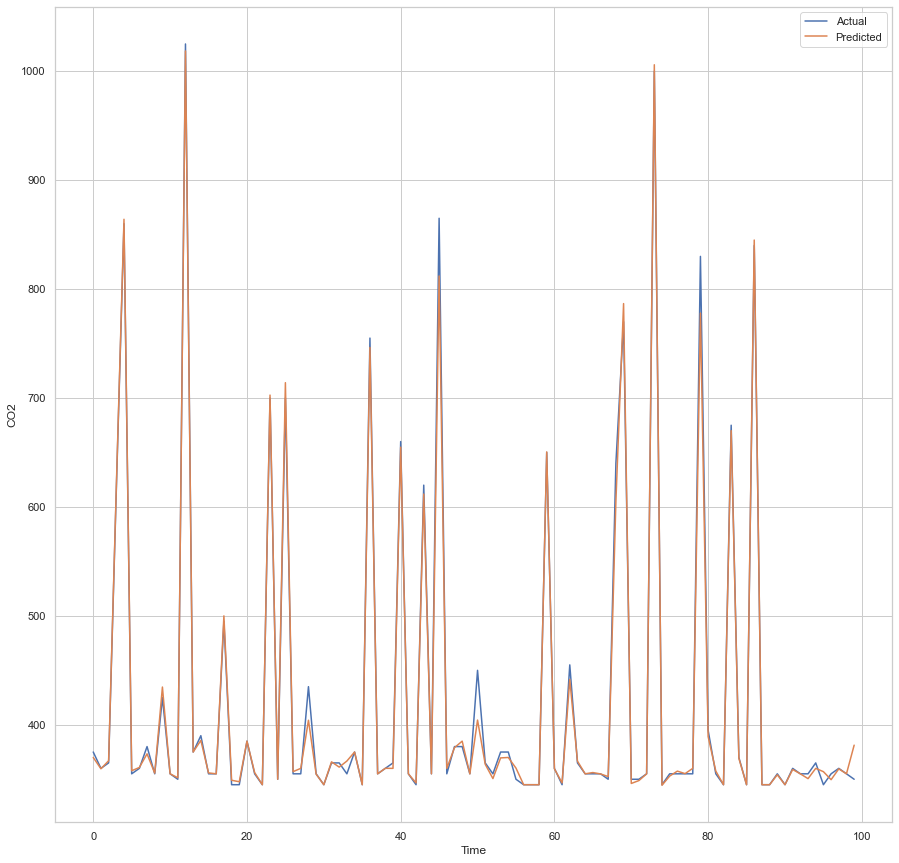

In [62]:
# Set the figure size
plt.figure(figsize=(15, 15))

# Plot the first 100 actual CO2 values and the predicted values over time
plt.plot(y_test.values[0:100], label='Actual')
plt.plot(y_pred[0:100], label='Predicted')
plt.xlabel('Time (Steps)')
plt.ylabel('CO2')
plt.legend()
plt.show()

In [63]:
# Calculate root mean squared error (RMSE) and R2 score for the predictions
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Print the RMSE and R2 score
print("RMSE:", rmse)
print("R2 score:", r2)

# Mean absolute error
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

RMSE: 10.154721183682145
R2 score: 0.9943624538864625
Mean Absolute Error: 4.41909224185002


XGBoost was affected the most after removing outliers. While RMSE and MAE decreased with RMSE: 10.154721183682145, R2 score: 0.9943624538864625, Mean Absolute Error: 4.41909224185002 and got closer to true values. Still, we lost little bit in accuracy of a model.

In [64]:
# Convert CO2 levels to binary occupancy labels using a threshold of 1000 ppm
y_test_occ = np.where(y_test > 1000, 1, 0)
y_pred_occ = np.where(y_pred > 1000, 1, 0)

# Calculate precision, recall, F1-score and support for each class (occupied and unoccupied)
precision, recall, f1, support = precision_recall_fscore_support(y_test_occ, y_pred_occ)

# Print the F1-score for the occupied class
print("F1-score for occupied class:", f1[1])


F1-score for occupied class: 0.8484848484848485


As we can see, the F1-score is less desirable than that from a data set without outliers. At the same time, we were able to reduce the RMSE and MAE, which is good. What does this actually mean? It means that the error of our model and precision of produced results is higher. At the same time, if we increase the MAE and our results fall within +/-6 instead of +/-4, our F1-score will increase. From personal experience, it means that those outliers are most likely not just outliers, and they should be investigated. It is possible that after acquiring more data for higher and lower bounds, we will be able to reduce the RMSE and MAE without trimming outliers or that the range of our outliers will decrease, which is also possible. Nevertheless, we think that removal of outliers decrease bias and keep integrity of produced results with in scientific methods.

In [65]:
# Calculate bias
bias = np.mean(y_pred) - np.mean(y_test)
print("Bias:", bias)

Bias: 0.09471083070599207


Last, but not least, the bias is 0.094 and it decreased dramatically. In some sense, it is an outstanding result. If we compare all models, XGBoost is probably the model with the least bias and the closest to the true value. It is not clear which model would perform the best in the real world, and more research must be done in that direction. Nevertheless, it is clear that there are two leading models: Deep Learning and Gradient Boosting models. It is likely that a final model will involve one of those models.